# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-3])

# add integration folder to current working path
sys.path.append(parent_directory+"/Src/integration")

# add utils folder to current working path
sys.path.append(parent_directory+"/Src/utils")

# add Algorithm folder to current working path in order to access the functions
sys.path.append(parent_directory+"/Demos/EllipticOECS")

In [2]:
# Suppress numba warnings arising from computation falling back into object mode.
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

# Overview

In the following notebok we extract elliptic OECS in the Agulhas region from the AVISO dataset. The notebook is structured as follows:

* Import data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'
<br />
* Define computational parameters (such as the number of cores) and variables
 <br />
* Define spatio-temporal domain over which to compute the elliptic OECS.
 <br />
* Interpolate velocity from the (discrete) gridded data using a cubic spline interpolation <br />
* Compute rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $ over meshgrid of initial conditions '$ \mathbf{x} $' at time '$t$' <br />
* Compute elliptic OECS as closed null geodesics of $ \mathbf{S}(\mathbf{x}, t)-\mu I $.

# Import Data

We start by import the AVISO-data from the file 'Agulhas_AVISO.mat' stored in the folder 'Data'.

In [3]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../Data/AVISO/Agulhas_AVISO.mat')

#U = mat_file['u']
#V = mat_file['v']
#x = mat_file['x']
#y = mat_file['y']
#time = mat_file['t']

mat_file = sio.loadmat('../../../Data/AVISO/ocean_velocity_example_diffusive.mat')

U = mat_file['vx'].transpose()
V = mat_file['vy'].transpose()
x = mat_file['xc'].transpose()
y = mat_file['yc'].transpose()
time_data = mat_file['time'].transpose()

CPU times: user 37 ms, sys: 16.2 ms, total: 53.2 ms
Wall time: 51.9 ms


# Data/Parameters for Dynamical System

In [4]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 8

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## compute meshgrid of dataset
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-Temporal Domain of Dynamical System

In [5]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

CPU times: user 1.42 ms, sys: 1.97 ms, total: 3.39 ms
Wall time: 2.07 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant. 

In [6]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 70.3 ms, sys: 21.9 ms, total: 92.2 ms
Wall time: 95.2 ms


# Rate of strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The method *DS._spin_tensor(x, t)* computes the rate of strain tensor at point $ \mathbf{x} $  at time $ t $ by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $. The computations are parallelized.

In [7]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import Rate of Strain function
from ipynb.fs.defs.RateStrain import RateStrain

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

def parallel_S(i):
    
    S_parallel = np.zeros((X_domain.shape[1], 2, 2))
    
    for j in range(S_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # Compute gradient of velocity
        grad_vel = gradient_velocity(t_OECS, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
        # Compute rate of strain at 'x'
        S_parallel[j, :, :] = RateStrain(grad_vel)
    
    return S_parallel

S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/802 [00:00<?, ?it/s]

CPU times: user 15.9 s, sys: 5.6 s, total: 21.5 s
Wall time: 39.7 s


# Compute Tensorfield Properties

We now compute the properties of the rate of strain tensor 'S' such as the eigenvalues 's1', 's2' and eigenvectors 'eigenv1', 'eigenv2'. Furthermore, we also need the spatial derivatives of the elements of 'S'.

In [8]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute gradients of elements of rate of strain tensor

S11 = np.nan_to_num(S[:,:,0,0], nan=0.0)
S12 = np.nan_to_num(S[:,:,0,1], nan=0.0)
S22 = np.nan_to_num(S[:,:,1,1], nan=0.0)
    
# Interpolate elements of rate of strain tensor (per default: cubic)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], S11)
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], S12)
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], S22)

# Initialize arrays
S11x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S11y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22y = np.zeros((S.shape[0], S.shape[1]))*np.nan
    
# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [9]:
%%time
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y)

CPU times: user 4.74 s, sys: 544 ms, total: 5.29 s
Wall time: 2.15 s


# Find closed null-geodesics of $ S − \mu I $

Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ S(\mathbf{x}, t) − \mu $. $ \mu ∈ \mathbb{R} $ denotes the tangential stretch rate along an elliptic OECS. For perfectly coherent elliptic OECS with no tangential stretchin (=filamentation) it holds that $ \mu = 0 $.  

In [10]:
%%time
# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import _closed_null_geodesics

# extract elliptic OECS from closed null geodesics
from ipynb.fs.defs.elliptic_OECS import _elliptic_OECS

# define mu range
mu_min = -0.01
mu_max = 0.01
n_mu = 20
mu_range = np.linspace(mu_min, mu_max, n_mu)

# parameter specifying sparsity of initial conditions. 
# Increasing this parameter reduces the number of initial conditions and thereby reduces the computational time involved.
# For maximal accuracy set sparse_ic = 1. This implies that we use the resolution of the meshgrid. 
# This value should always be at least 1.
sparse_ic = 2

# threshold distance for periodicity of trajectory
d_threshold = dx

# compute Elliptic OECS
# If you do not want to use parallel computing, then set n_jobs = 1
elliptic_OECS = []

# Initial conditions of mu
init_mu_range = []

for mu in mu_range:
    
    print("Compute elliptic OECS for mu =", np.around(mu, 3))
    
    # Define list storing x, y coordinates of elliptic OECS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_null_geodesics, init_mu = _closed_null_geodesics(X_domain, Y_domain, mu, interp_phi_prime, d_threshold, S11, interp_DOE, sparse_ic, Ncores)
    
    # Append initial conditions to list 
    init_mu_range.append(init_mu)
        
    # Extract elliptic OECS
    x_elliptic, y_elliptic = _elliptic_OECS(closed_null_geodesics)
            
    elliptic_OECS.append([x_elliptic, y_elliptic])

Compute elliptic OECS for mu = -0.01


  0%|          | 0/2347 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.009


  0%|          | 0/2340 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.008


  0%|          | 0/2331 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.007


  0%|          | 0/2324 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.006


  0%|          | 0/2313 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.005


  0%|          | 0/2318 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.004


  0%|          | 0/2307 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.003


  0%|          | 0/2297 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.002


  0%|          | 0/2284 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = -0.001


  0%|          | 0/2269 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.001


  0%|          | 0/2258 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.002


  0%|          | 0/2250 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.003


  0%|          | 0/2245 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.004


  0%|          | 0/2242 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.005


  0%|          | 0/2238 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.006


  0%|          | 0/2234 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.007


  0%|          | 0/2228 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.008


  0%|          | 0/2229 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.009


  0%|          | 0/2225 [00:00<?, ?it/s]

Finished integration of closed null geodesics
Compute elliptic OECS for mu = 0.01


  0%|          | 0/2223 [00:00<?, ?it/s]

Finished integration of closed null geodesics
CPU times: user 1h 35min 50s, sys: 56.5 s, total: 1h 36min 47s
Wall time: 1h 45min 40s


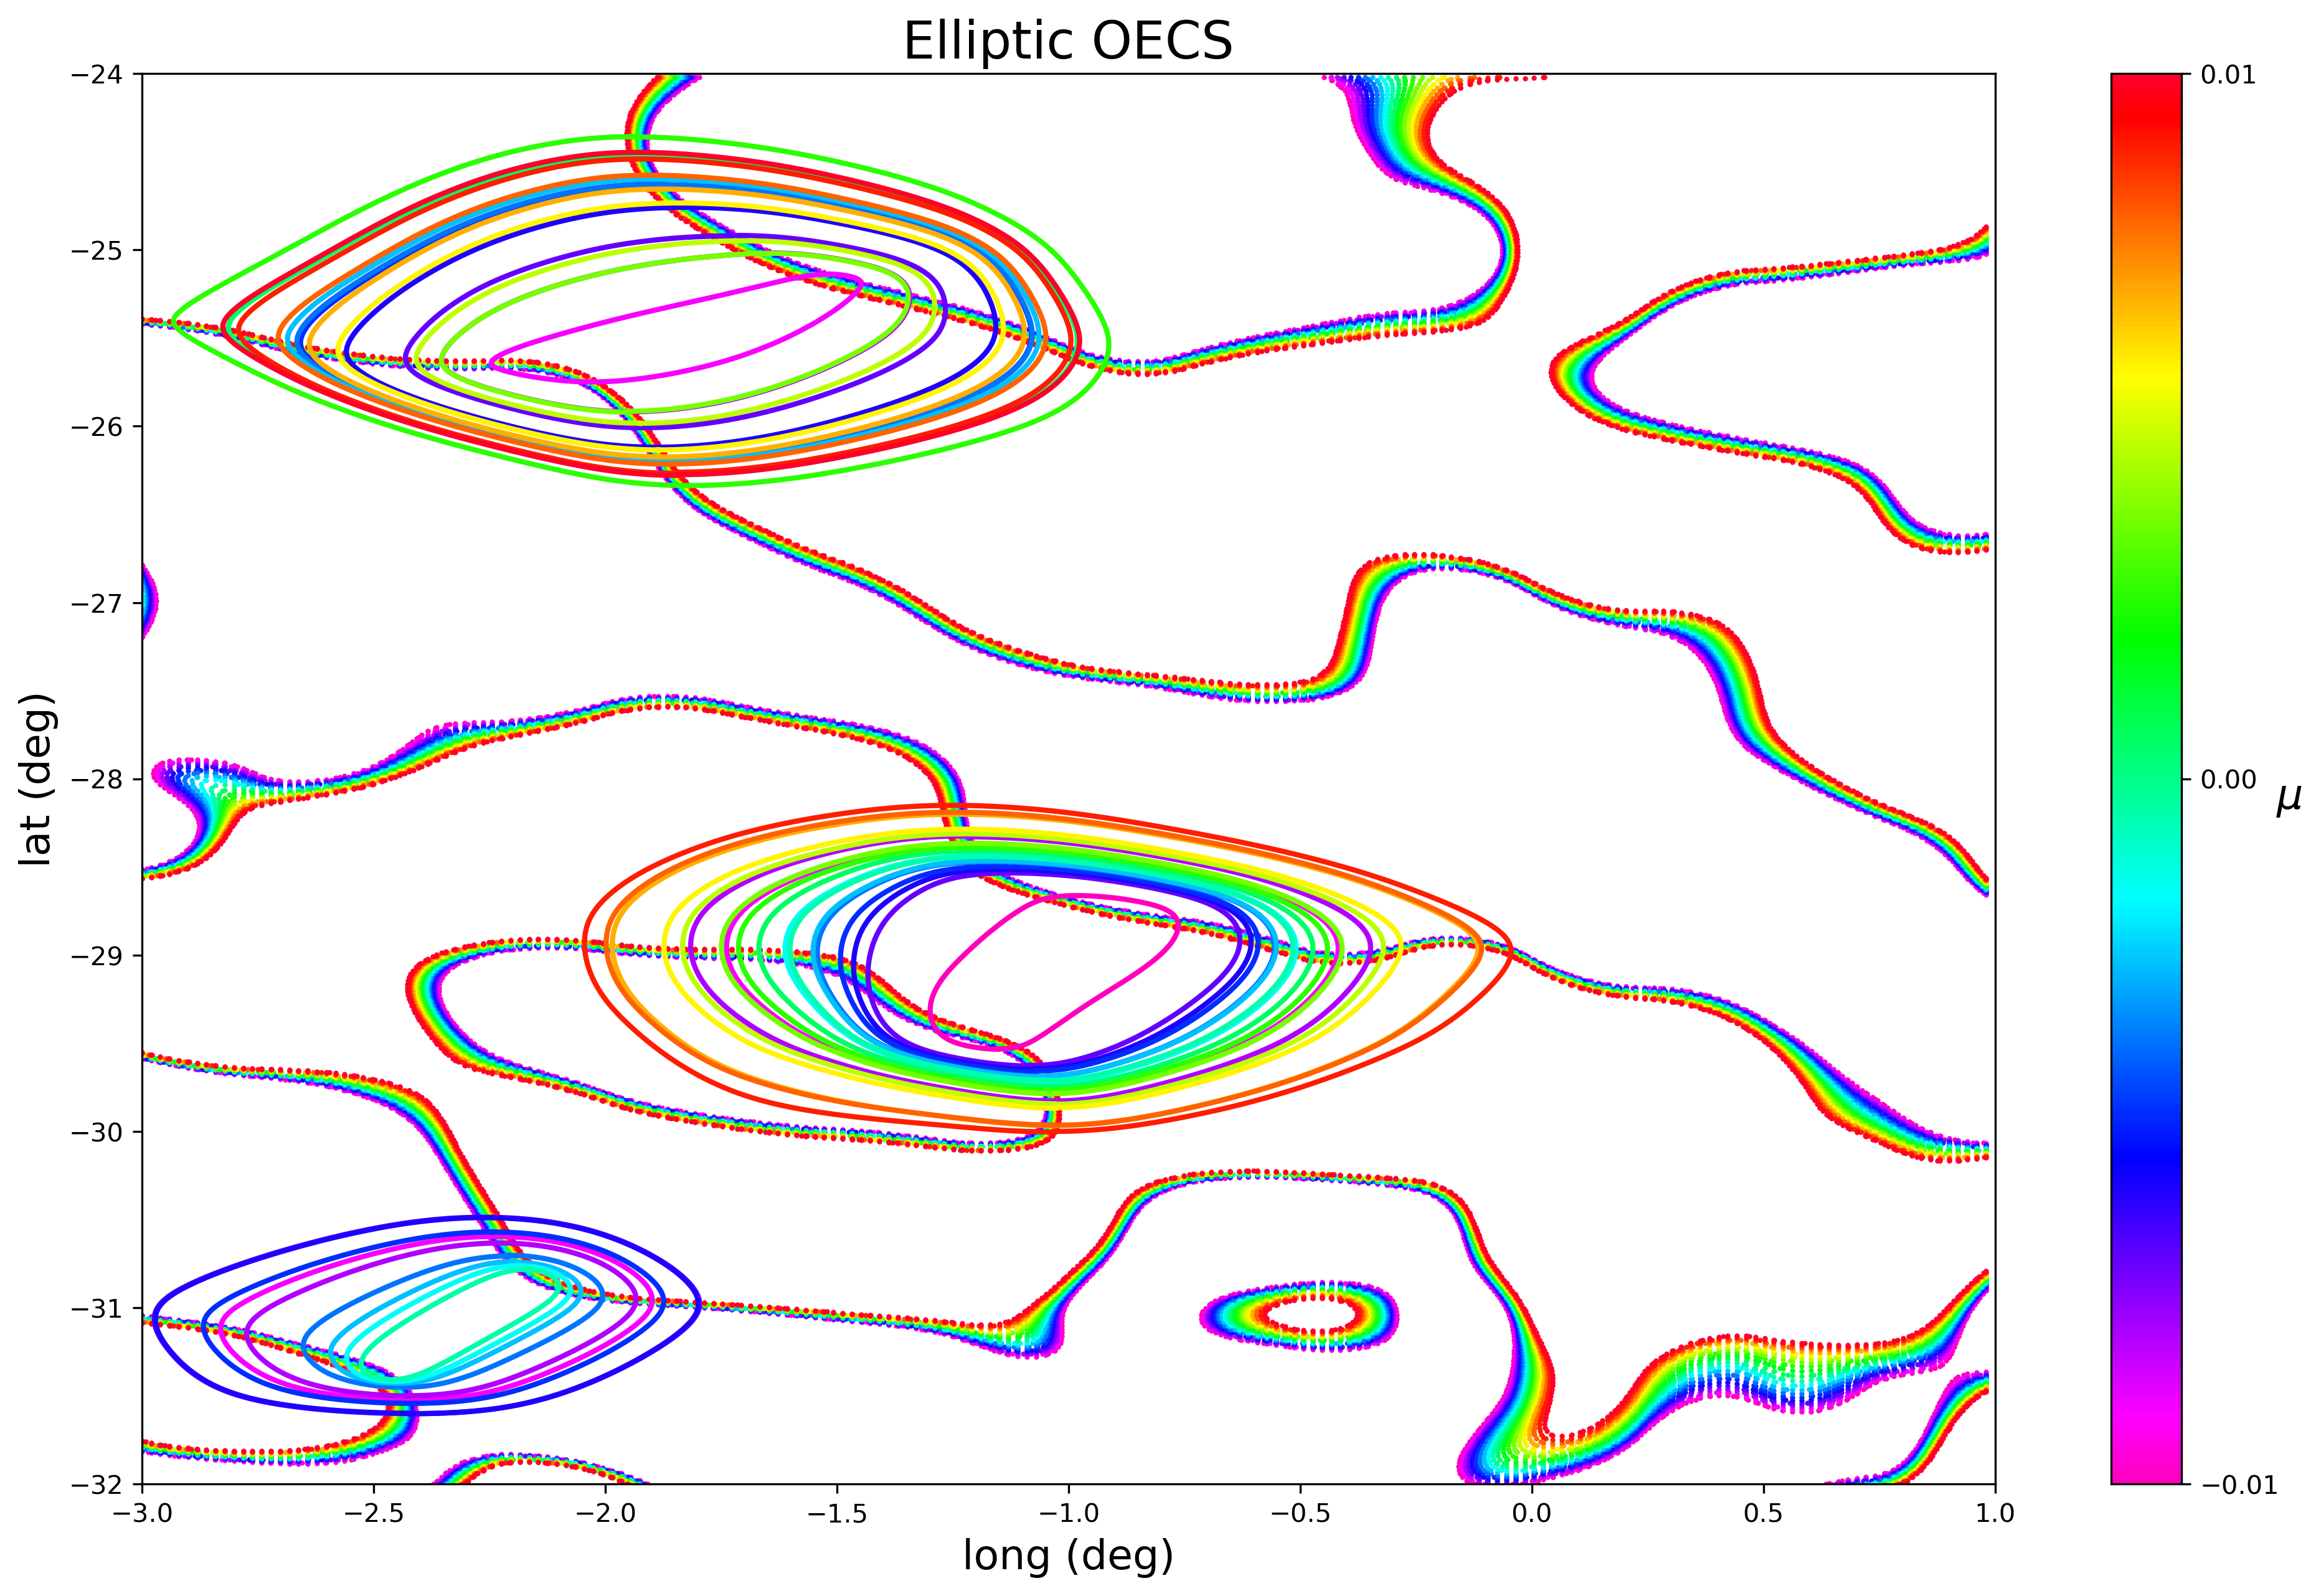

In [11]:
######################################## Plot elliptic OECS ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 300)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=mu_range.min(), vmax=mu_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')#mpl.cm.jet)

# Iterate over all elliptic OECS and plot
for i in range(len(elliptic_OECS)):
    
    ax.scatter(init_mu_range[i][0], init_mu_range[i][1], s = 1, color=cmap.to_rgba(mu_range[i]))
    
    if elliptic_OECS[i][0] is not None:
    
        for j in range(len(elliptic_OECS[i][0])):
        
            if elliptic_OECS[i][0][j] is not None:
        
                ax.plot(elliptic_OECS[i][0][j], elliptic_OECS[i][1][j], c=cmap.to_rgba(mu_range[i]), linewidth = 2)

# Set axis limits
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Colorbar
cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 16)

# Title
ax.set_title("Elliptic OECS", fontsize = 20)
plt.show();